In [15]:
# 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123621 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

In [31]:
# 1. 샘플링 관련 import 구문
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')


import imblearn
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN


In [3]:
# 2. 샘플링 관련 버전 확인
print("라이브러리 버전 체크")
print("넘파이 버전: ", np.__version__)
print("판다스 버전 : ", pd.__version__)
print("씨본 버전 : ", sns.__version__)
print("맷플랏립 버전 : ", mpl.__version__)
print("아이엠비런 버전 : ", imblearn.__version__)


라이브러리 버전 체크
넘파이 버전:  1.26.4
판다스 버전 :  2.2.2
씨본 버전 :  0.13.2
맷플랏립 버전 :  3.7.1
아이엠비런 버전 :  0.12.4


In [18]:
# 3. 글자 깨짐 맞추기

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper")
sns.set_palette("Set2")
sns.set_style("whitegrid")

plt.rc("font", family = "Nanum Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [7]:
# 4. 데이터 불러오기
df = pd.read_csv("/content/sampling_data.csv",
                 index_col=0)
df

# 총 600개의 데이터 확인
# column으론 x,y,label이 존재함.

,x,y,label
0,3.187033,-0.898236,0
1,-1.915836,-1.274032,0
2,0.972633,2.210568,0
3,1.544475,-1.119704,0
4,-1.655932,3.475853,0
...,...,...,...
595,3.840733,-1.014288,1
596,2.739044,2.972257,1
597,0.124288,-0.396358,1
598,2.926877,-1.308006,1


In [9]:
# 5. label 값 확인하기(0과 1 그 이외의 값은 있는지, 그리고 개수는 몇개인지 확인 )
df["label"].value_counts()

,count
label,
0,500
1,100


[Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$'), Text(0.5, 1.0, 'Origin')]

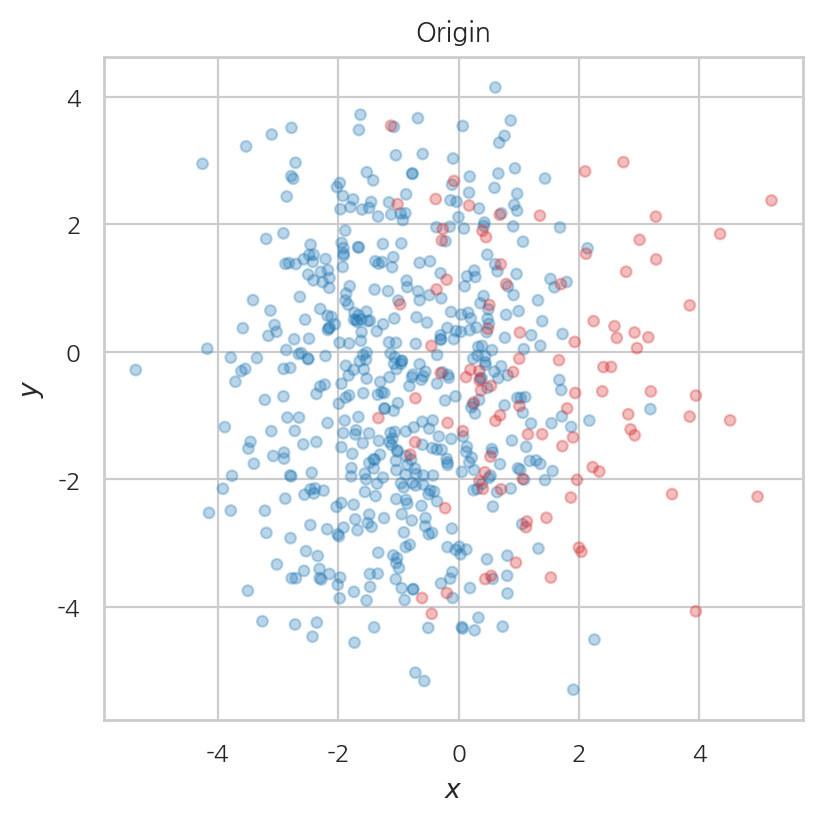

In [32]:
# 6. scatter plot(산점도) 이용해서 분포도를 확인해보기

# label 값 0을 blue로 1을 red로 구별
colors = {0: "tab:blue", 1:"tab:red"}
c = df["label"].replace(colors)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(df["x"], df["y"], s=15, alpha = 0.3, color=c)
ax.set(xlabel = R"$x$",
       ylabel = R"$y$",
       title = "Origin")


# 1. UnderSampling

In [26]:
# 1. 0과 1을 각각 파랑색과 빨강색으로 나누는 함수
def color(arr):
  c = []
  for i in arr:
    if i == 0:
      c.append("tab:blue")
    else:
      c.append("tab:red")
  return c


In [22]:
# 2. 산점도 그리는 함수
def sampler_img(x, y, name):
  fig, (ax_origin, ax_sampling) = plt.subplots(1,2, figsize = (6,3))

  ax_origin.scatter(df["x"], df["y"],
                    s = 15,
                    alpha = 0.3,
                    color=c)

  ax_origin.set(xlabel=R"$X$",
                ylabel=R"$Y$",
                title="Origin")
  ax_sampling.scatter(x[:,0],x[:,1],
                      s = 15,
                      alpha = 0.3,
                      color=color(y))
  ax_sampling.set(xlabel = R"$X$",
                  ylabel = R"$Y$",
                  title = f"{name}");

In [23]:
# 3. 훈련할 값 지정하기
x_train = df[["x","y"]].values
y_train = df["label"].values

## 1.1 Random Under Sampler
- 다수 class 데이터에서 random하게 제거하여 소수 class 데이터량에 맞춤

In [24]:
rus = RandomUnderSampler(random_state=0)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

np.unique(y_rus, return_counts=True)

(array([0, 1]), array([100, 100]))

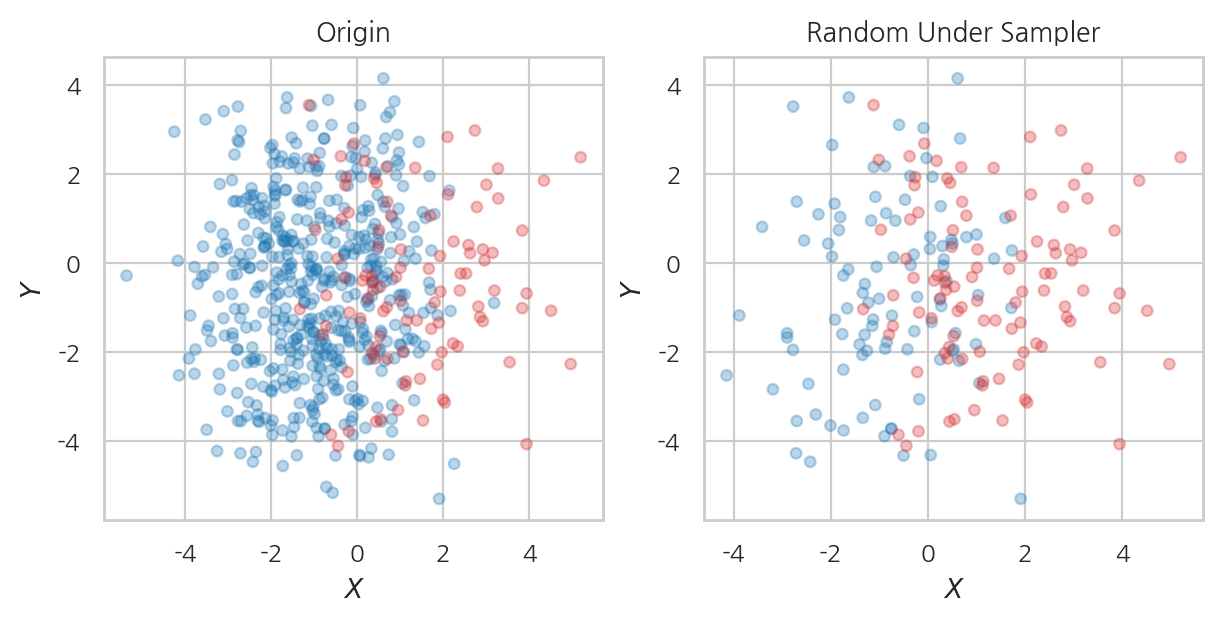

In [33]:
sampler_img(x_rus, y_rus, "Random Under Sampler")

# 1.2 Edited Nearest Neighbors
- 다수 class 데이터에서 $k$개 (`n_neighbors`)의 Euclidean distance가 가까운 점을 찾고, 소수 class가 많이 섞여있으면 제거
-`kind_sel = "all"` 이면 주변에 모두 소수 class일 경우 제거
- 소수 class 주변에 다수의 class가 제거됨


In [29]:
# 1. ENN 호출
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
x_enn, y_enn = enn.fit_resample(x_train, y_train)

np.unique(y_enn, return_counts=True)

(array([0, 1]), array([330, 100]))

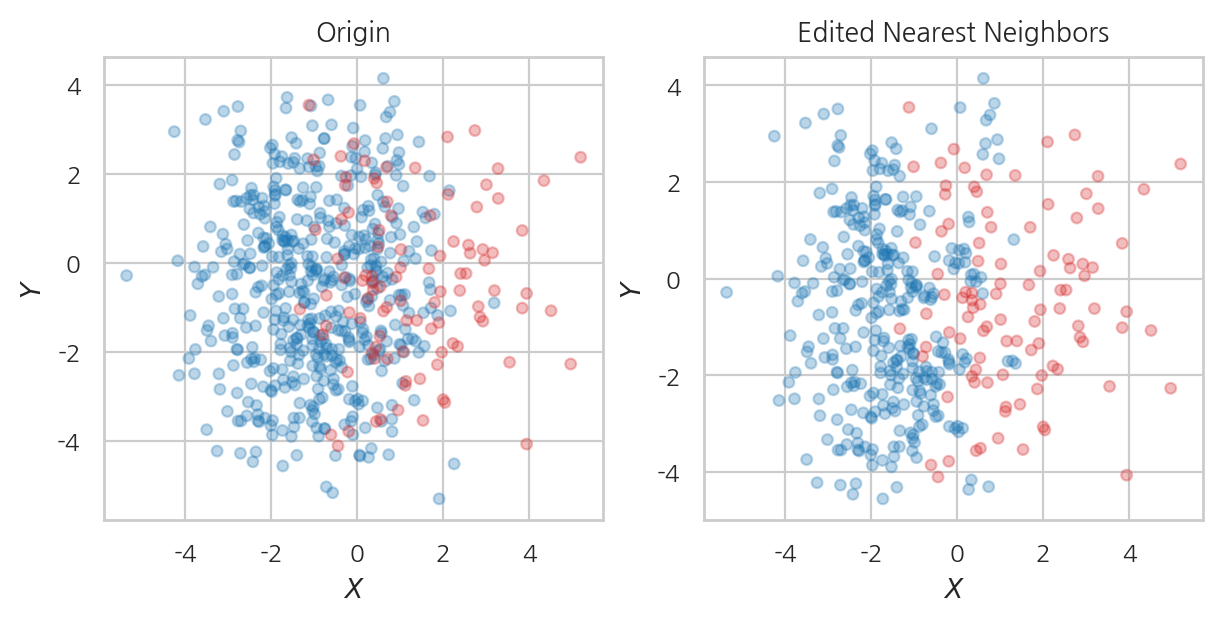

In [34]:
# 2. ENN 관련 산점도 그림
sampler_img(x_enn, y_enn, "Edited Nearest Neighbors")

# 2.1 Random Over Sampler
- 소수 class를 랜덤하게 증가시킴
- 같은 데이터를 반복 생성하여 다수 class에 맞춤

In [42]:
ros = RandomOverSampler(random_state=0)
x_ros, y_ros = ros.fit_resample(x_train, y_train)
np.unique(y_ros, return_counts=True)

(array([0, 1]), array([500, 500]))

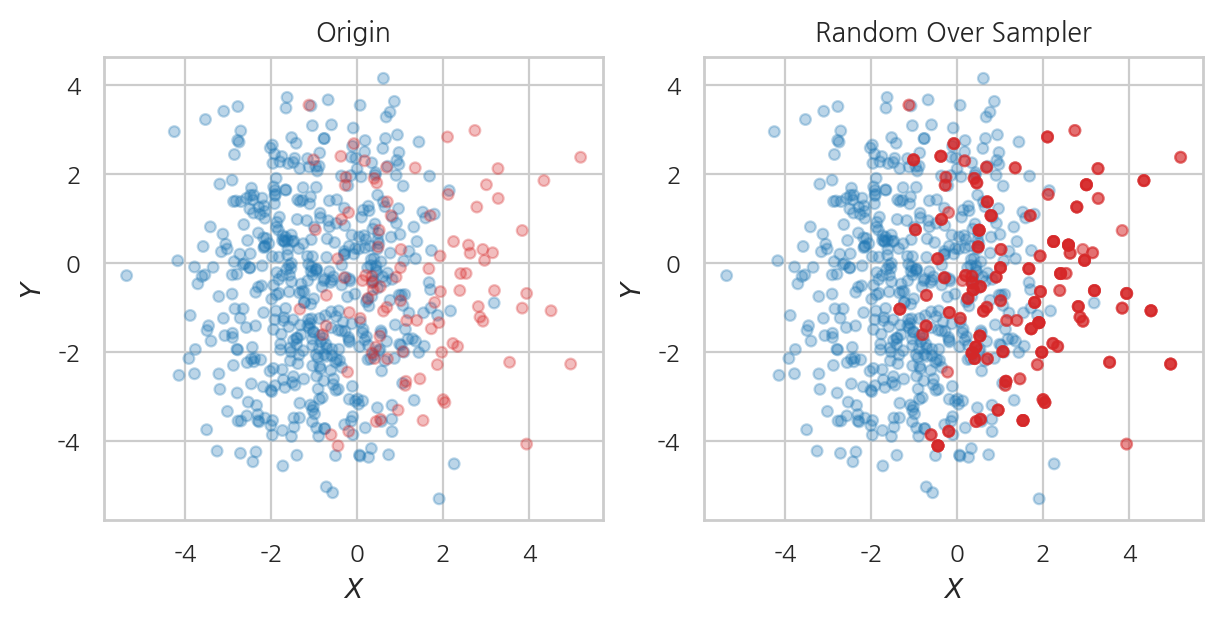

In [43]:
sampler_img(x_ros, y_ros, "Random Over Sampler")

# 2.2 SMOTE
- 소수의 class에서 임의의 점 $a$를 선택
- $a$와 같은 class에서 Euclidean distance가 가까운 5개 (`k_neighbors`)의 점을 찾아 임의로 $b$를 선택.
- $a$와 $b$ 사이에 새로운 데이터를 생성함.

In [35]:
smote = SMOTE(random_state=0)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

np.unique(y_smote, return_counts=True)

(array([0, 1]), array([500, 500]))

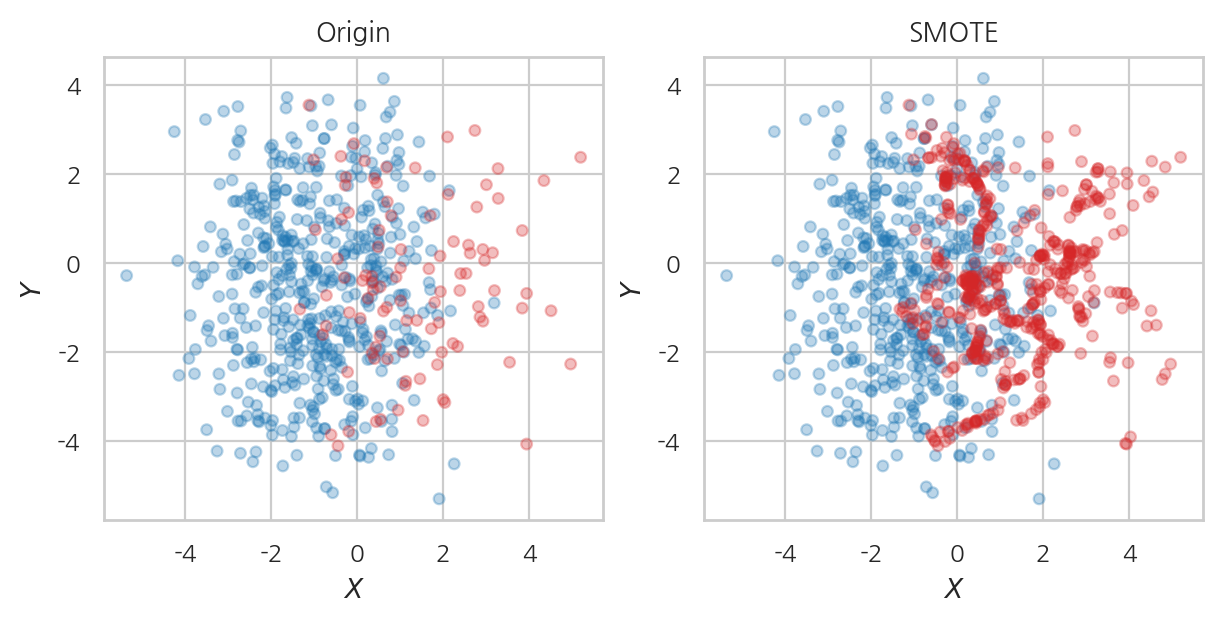

In [36]:
sampler_img(x_smote,y_smote, "SMOTE")

# 3. 혼합 : Combining Over and UnderSampling: SMOTEENN (SMOTE + ENN)
- 다수의 class는 SMOTE 방식으로 줄임.
- 소수의 class는 ENN 방식으로 늘임.

In [37]:
smoteenn = SMOTEENN(random_state=0)
x_smoteenn, y_smoteenn = smoteenn.fit_resample(x_train, y_train)

np.unique(y_smoteenn, return_counts=True)

(array([0, 1]), array([320, 325]))

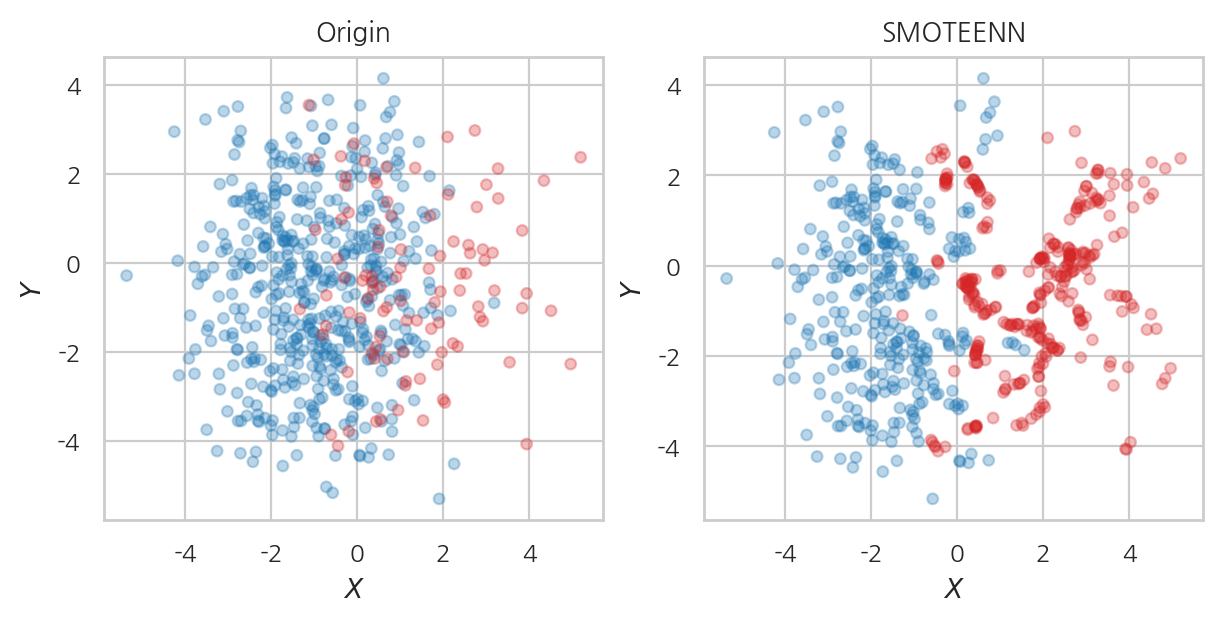

In [41]:
sampler_img(x_smoteenn, y_smoteenn, "SMOTEENN")

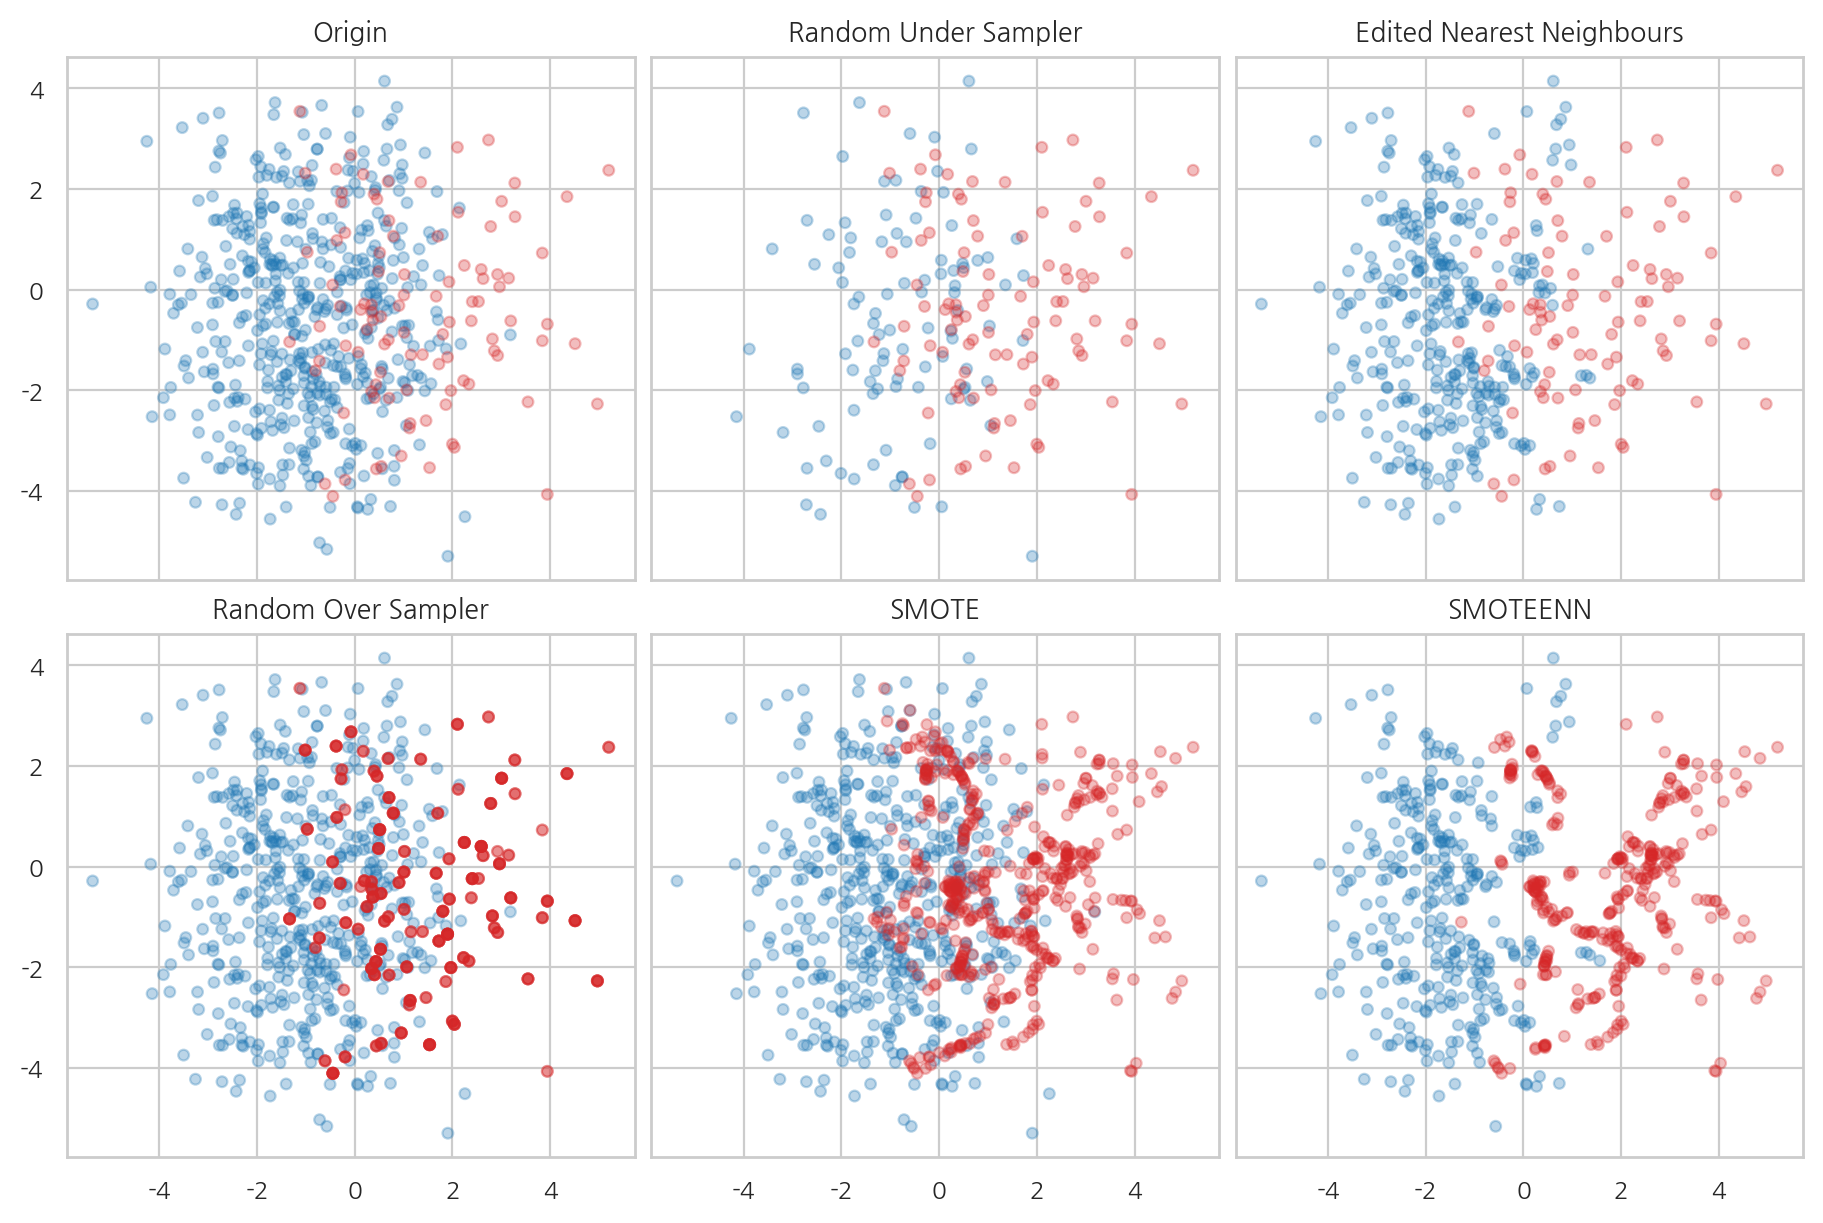

In [44]:
# 모아보기

fig, axes = plt.subplots(2, 3, figsize=(9,6), sharex=True, sharey =True)

sampling = {"Origin" : [x_train, y_train],
            "Random Under Sampler": [x_rus, y_rus],
            "Edited Nearest Neighbours": [x_enn, y_enn],
            "Random Over Sampler": [x_ros, y_ros],
            "SMOTE": [x_smote, y_smote],
            "SMOTEENN": [x_smoteenn, y_smoteenn]}

for name, ax in zip(sampling.keys(), axes.flat):
  ax.scatter(sampling[name][0][:,0],
             sampling[name][0][:,1],
             s = 15,
             alpha = 0.3,
             color = color(sampling[name][1]))
  ax.set(title = f"{name}")